In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import mrcfile

# Load density map

In [8]:
data_directory = pathlib.Path('..') / 'data'  # directory where the data is
map_dir = data_directory / 'EMPIAR' / '10077'

In [9]:
id = 4121
fname = f'emd_{id}.map.gz'

In [10]:
with mrcfile.open(f'{str(map_dir)}/{fname}') as mrc:
    volume = mrc.data
print(f'> Loaded map of shape: {volume.shape}')

FileNotFoundError: [Errno 2] No such file or directory: '../data/EMPIAR/10077/emd_4121.map.gz'

In [5]:
def show_volume(volume, mode='sum', axis='Z', bins=100):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(121)
    display_volume(volume, mode=mode, axis=axis, dimension=2)
    plt.subplot(122)
    display_hist(volume.flatten(), bins=bins)
    plt.show()
    
def display_volume(volume, mode='sum', axis='Z', dimension=2, cmap='Greys'):
    #display_dimension = 2
    nx = volume.shape[0]
    if(dimension < 3):
        if(mode=='sum'):
            if(axis=='X'):
                numaxis=0
            elif(axis=='Y'):
                numaxis=1
            elif(axis=='Z'):
                numaxis=2
            plt.imshow(np.sum(volume,axis=numaxis), cmap=cmap)
        elif(mode=='slice'):
            if(axis=='X'):
                plt.imshow(volume[int(nx/2),...], cmap=cmap)
            elif(axis=='Y'):
                plt.imshow(volume[:,int(nx/2),:], cmap=cmap)
            elif(axis=='Z'):
                plt.imshow(volume[:,:,int(nx/2)], cmap=cmap)
        plt.colorbar()

def display_hist(volume, bins=10):
    plt.hist(volume, bins=bins, log=True, color='grey')
    plt.grid()
    plt.show()

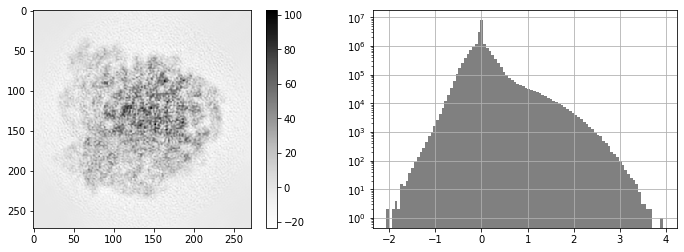

In [12]:
show_volume(volume)

In [17]:
#https://terbium.io/2017/12/matplotlib-3d/
#to visualize the 3d map
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
IMG_DIM = 32

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def explode(data):
    """
    Create a 3d array twice as large in each dimension (extra space between each voxel)
    inputs:
        data(3D np.array): (n,n,n)
    returns:
        exploded(3D np.array): (2n,2n,2n)
    """
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)

    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)

    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)

    ax.voxels(x, y, z, filled, facecolors=facecolors)
    plt.show()

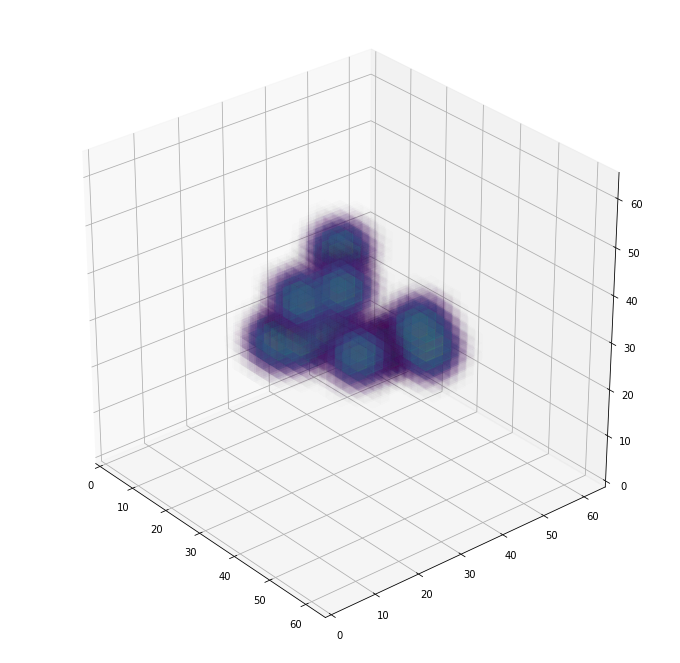

In [18]:
plot_cube(density_volume)

[32 32 32  4]


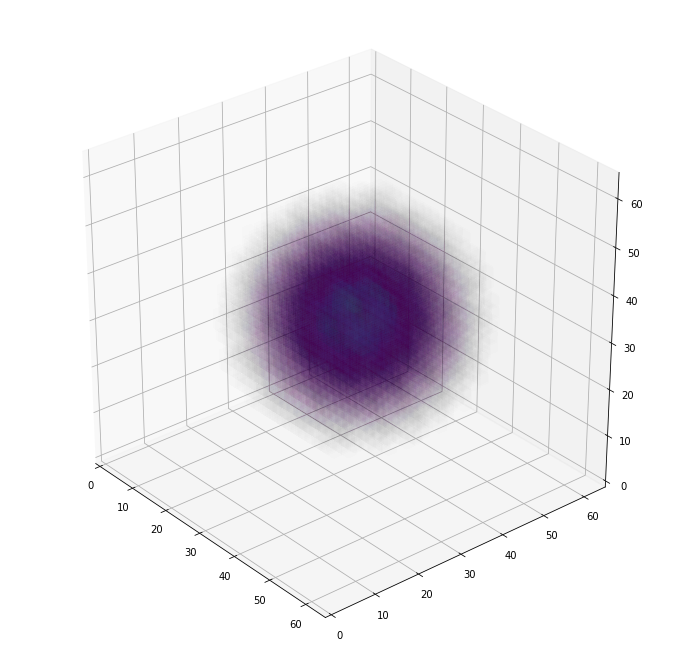

In [6]:
volume = np.load('generated_dataset/reconstructed map of dataset 3 atoms (1000 images).npy')
vol_ft = np.fft.fftn(volume)
vol_shift = np.fft.fftshift(vol_ft)

plot_cube(np.absolute(vol_shift))

# Create density map
here we just define a few randomly placed atoms. We could also read their cartesian coordinates from a PDB file (to be done).

In [147]:
def init_crds(natom=2, R=10.):
    """init_crds"""
    crds  = np.random.rand(natom, 3)*R
    crds -= np.mean(crds, axis=0)
    rads  = 1*np.ones(natom)
    return crds, rads

def init_volume(n, L, crds=None, rads=None):
    """init_volume: WAY TO SLOW, TO BE OPTIMIZED
    """
    index  = np.arange(n)
    volume = np.zeros((n,n,n))
    ctr = 0
    for i in index:
        posx = -L/2 + i*L/(n-1)
        for j in index:
            posy = -L/2 + j*L/(n-1)
            for k in index:
                posz = -L/2 + k*L/(n-1)
                for iat in np.arange(crds.shape[0]):
                    dx = crds[iat,0] - posx
                    dy = crds[iat,1] - posy
                    dz = crds[iat,2] - posz
                    dist2  = dx*dx + dy*dy + dz*dz
                    if(dist2 <= 100):
                        dist2 /= rads[iat]**2
                        volume[i,j,k] += np.exp(-0.5*dist2)
                        ctr +=1
    print(ctr)                    
    return volume

def init_volume_bis(n, L, crds=None, rads=None):
    """
    """
    ctr = 0
    volume = np.zeros((n,n,n))

    for iat in range(len(crds)):
        #coordinate of the voxel that contains the center of the particle
        i0 = int((crds[iat][0]+L/2)*(n-1)/L)
        j0 = int((crds[iat][1]+L/2)*(n-1)/L)
        k0 = int((crds[iat][2]+L/2)*(n-1)/L)
        
        dx = crds[iat][0]-(-L/2 + i0*L/(n-1))
        if dx>L/2/(n-1):
            i0 +=1
            dx-=L/(n-1)
        dy = crds[iat][1]-(-L/2 + j0*L/(n-1))
        if dy>L/2/(n-1):
            j0 +=1
            dy-=L/(n-1)
        dz = crds[iat][2]-(-L/2 + k0*L/(n-1))
        if dz>L/2/(n-1):
            k0 +=1
            dz-=L/(n-1)

        sup_i = int((dx+10)*(n-1)/L)
        inf_i = np.ceil((dx-10)*(n-1)/L)
        
        index_i = np.arange(max(inf_i, -i0), min(sup_i+1, n-i0))
        for i in index_i:
            
            sup_j = int((n-1)/L*dy + np.sqrt(100*((n-1)/L)**2-(i-(n-1)/L*dx)**2))
            inf_j = np.ceil((n-1)/L*dy - np.sqrt(100*((n-1)/L)**2-(i-(n-1)/L*dx)**2))
            
            index_j = np.arange(max(inf_j, -j0), min(sup_j+1, n-j0))
            dist_x = (i*L/(n-1)+dx)**2

            for j in index_j:
                
                sup_k = int((n-1)/L*dz + np.sqrt(100*((n-1)/L)**2-(i-(n-1)/L*dx)**2 -(j-(n-1)/L*dy)**2))
                inf_k = np.ceil((n-1)/L*dz - np.sqrt(100*((n-1)/L)**2-(i-(n-1)/L*dx)**2 -(j-(n-1)/L*dy)**2))

                index_k = np.arange(max(inf_k, -k0), min(sup_k+1, n-k0))
                dist_y = (j*L/(n-1)+dy)**2

                for k in index_k:
                    
                    dist_z = (k*L/(n-1)+dz)**2
                    volume[int(i0+i),int(j0+j),int(k0+k)] += np.exp(-0.5*(dist_x*dist_x+dist_y*dist_y +dist_z*dist_z))
                    ctr+=1
    
    print(ctr)
    return volume
                

In [153]:
density_volume_bis = init_volume_bis(64, 25., 
                             crds=atomic_coordinates,
                             rads=atomic_radii)

659956


In [150]:
atomic_coordinates, atomic_radii = init_crds(natom=10)
density_volume = init_volume(64, 25., 
                             crds=atomic_coordinates,
                             rads=atomic_radii)

659954


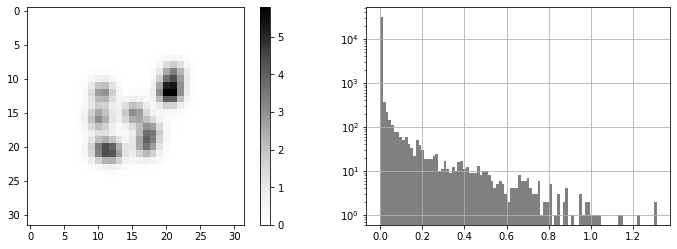

In [15]:
show_volume(density_volume)